In [29]:
import os
import cv2
import dlib
from pygame import mixer
import imutils
import numpy as np
from imutils import face_utils
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [30]:
# Ensure the directory for saving faces exists
if not os.path.exists("saved_faces"):
    os.makedirs("saved_faces")

In [31]:
# Initialize the mixer and load the alert sound
mixer.init()
mixer.music.load("music.wav")

In [32]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[1], mouth[7])
    B = distance.euclidean(mouth[2], mouth[6])
    C = distance.euclidean(mouth[3], mouth[5])
    D = distance.euclidean(mouth[0], mouth[4])
    return (A + B + C) / (2.0 * D)

In [33]:
# Thresholds and parameters for drowsiness detection
EAR_THRESHOLD = 0.20
EAR_MAJOR_THRESHOLD=0.10
MAR_THRESHOLD = 0.60

In [34]:
# Initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detect = dlib.get_frontal_face_detector()
predict = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

In [35]:
# Grab the indexes of the facial landmarks for the left and right eye, respectively
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_68_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_68_IDXS["right_eye"]
(mstart, mend) = face_utils.FACIAL_LANDMARKS_68_IDXS["mouth"]

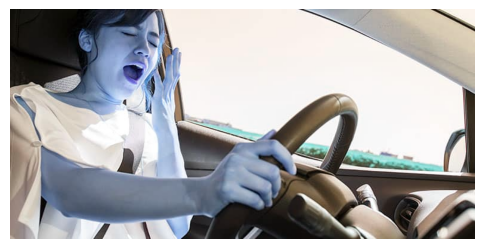

In [36]:
# Load an image from file
image_path = 'img4.jpg'
image = cv2.imread(image_path)
# image = imutils.resize(image)
# cv2.imwrite("saved_faces/face_main", image)
# Display the image using matplotlib
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

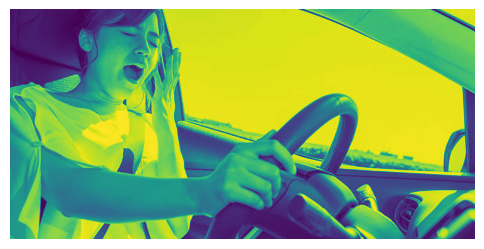

In [37]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 5, 1, 1)
# Apply histogram equalization to improve contrast
# gray = cv2.equalizeHist(gray)
plt.figure(figsize=(6, 6))
plt.imshow(gray)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [38]:
# Detect faces in the grayscale image
subjects = detect(gray)
print("Number of Faces detected : ",len(subjects))

Number of Faces detected :  1


In [39]:
for subject in subjects:
    shape = predict(gray, subject)
    shape = face_utils.shape_to_np(shape)

    # Extract the face region from the grayscale image
    (x, y, w, h) = face_utils.rect_to_bb(subject)
    face = gray[y : y + h, x : x + w]
    cv2.imwrite(f"saved_faces/face_untraced.png", face)

    # Extract the left and right eye coordinates
    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]
    mouth = shape[mstart:mend]

    # Calculate the EAR for both eyes
    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)
    mouthEAR = mouth_aspect_ratio(mouth)

    # Average the EAR
    ear = (leftEAR + rightEAR) / 2.0
    print(ear,mouthEAR)

    # Visualize the eye landmarks
    leftEyeHull = cv2.convexHull(leftEye)
    rightEyeHull = cv2.convexHull(rightEye)
    mouthHull = cv2.convexHull(mouth)
    
    cv2.drawContours(image, [leftEyeHull], -1, (0, 255, 0), 1)
    cv2.drawContours(image, [mouth], -1, (0, 255, 0), 1)
    cv2.drawContours(image, [rightEyeHull], -1, (0, 255, 0), 1)

    # Check if EAR is below the Threshold
    if ear < EAR_MAJOR_THRESHOLD:
        cv2.putText(
            image,
            "Drowsy",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 0, 255),
            2,
        )
        mixer.music.play()
    elif ear < EAR_THRESHOLD and mouthEAR >= MAR_THRESHOLD:
        cv2.putText(
            image,
            "Drowsy",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 0, 255),
            2,
        )
        mixer.music.play()
    else:
        cv2.putText(
            image,
            "No Drowsy",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255,0),
            2,
        )

0.19607238565482005 0.9363463083099522


In [40]:
# Display the image with the eye aspect ratio
cv2.imshow("Image", image)

# Save the image with landmarks for debugging purposes
cv2.imwrite("saved_faces/face_landmarks_0.png", image)

# Wait for a key press and close the image window
cv2.waitKey(0)
cv2.destroyAllWindows()